In [1]:
from datetime import datetime
print(f'Päivitetty {datetime.now().date()} / Aki Taanila')

Päivitetty 2024-03-21 / Aki Taanila


# Aikasarjaennustaminen - eri menetelmien kokeilua

### Ennustemenetelmien taustoja kannattaa opiskella osoitteessa https://otexts.com/fpp3/.

**Nixtla** https://www.nixtla.io/open-source mahdollistaa kehittyneiden ennustemenetelmien käytön myös aloittelevalle ennustajalle. 

Tässä muistiossa käytän Nixtlan **statsforecast**-kirjastoa https://github.com/Nixtla/statsforecast. Minicondan ja Anacondan käyttäjät voivat asentaa kirjaston komentorivillä komennolla `conda install -c conda-forge statsforecast`. Muut voivat asentaa kirjaston komennolla `pip install statsforecast`.

In [2]:
import pandas as pd

from statsforecast import StatsForecast

# Käytettävien mallien tuonti
from statsforecast.models import HoltWinters, AutoARIMA, AutoETS

# Mallien vertailuun
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

# Seuraava asetus sijoittaa tulostaulukoissa tunnistetiedot (id) omaksi muuttujakseen indeksin sijasta
# Ilman asetusta kaikki toimii, mutta ei välttämättä tulevissa versioissa
import os
os.environ['NIXTLA_ID_AS_COL'] = '1'

C:\Users\akita\miniconda3\Lib\site-packages\statsforecast\core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Aikasarjan valmistelu

Statsforecast-kirjastoa käytettäessä datasta täytyy löytyä muuttujat: 

* **unique_id** aikasarjan yksilöivä tunniste
* **ds** aikaleimat, joiden sijasta voidaan käyttää myös juoksevaa numerointia
* **y** aikasarjan arvot.

In [3]:
df = pd.read_csv('https://taanila.fi/beer.csv')
df

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9
...,...,...
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0


In [4]:
# Muunnetaan aikasarja statsdorecast-kirjaston edellyttämään muotoon
df['unique_id'] = 'Beer production'
df['ds'] = pd.to_datetime(df['Month'], format='%Y-%m')
df = df.drop('Month', axis=1)
df = df.rename(columns={'Monthly beer production':'y'})
df = df[['unique_id', 'ds', 'y']]
df.head()

,unique_id,ds,y
0,Beer production,1956-01-01,93.2
1,Beer production,1956-02-01,96.0
2,Beer production,1956-03-01,95.2
3,Beer production,1956-04-01,77.1
4,Beer production,1956-05-01,70.9


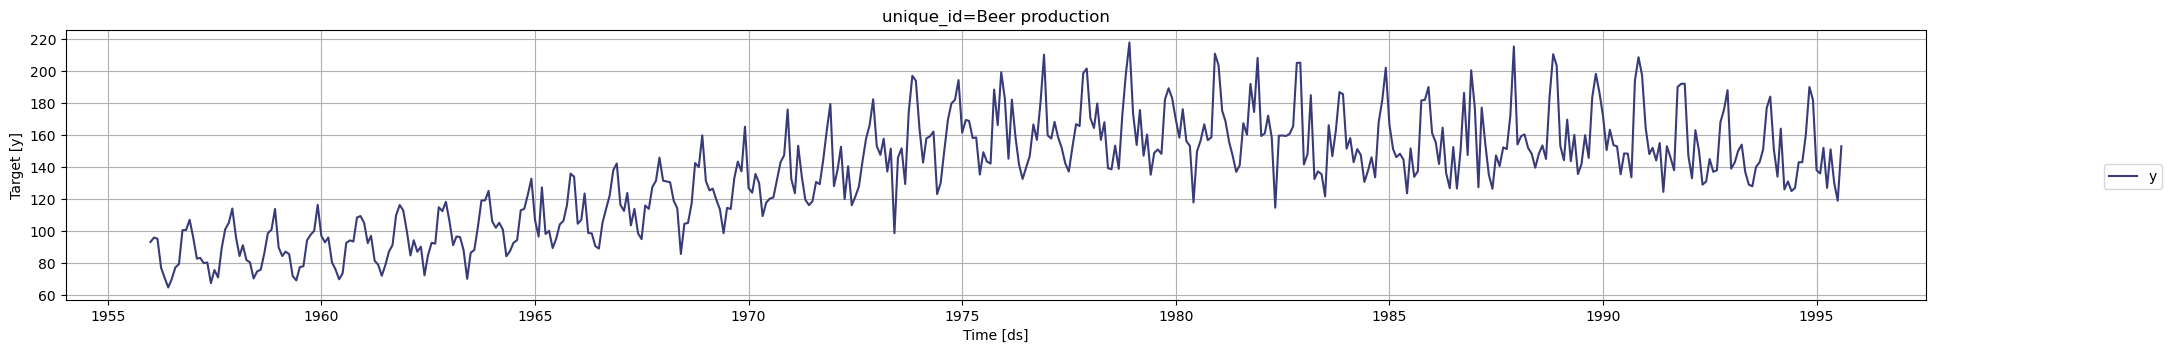

In [5]:
# Tarkistetaan miltä aikasarja näyttää grafiikkana
StatsForecast.plot(df)

## Mallit

Seuraavassa kokeilen kolmea statsforecast-kirjaston mallia

* **HoltWinters**, joka huomioi trendin ja kausivaihtelun. En määrittele etukäteen käsitelläänkö virheitä, trendiä ja kausivaihtelua additiivisesti (summamalli) vai multiplikatiivisesti (tulomalli), vaan annan algoritmin valita sopivimmat parametrit.
* **AutoARIMA**, joka kokeilee erilaisia parametrien kombinaatioita ja valitsee niistä sopivimman **AICc**-informaatiokriteerin perusteella. Lisätietoa https://otexts.com/fpp3/arima-estimation.html#information-criteria
* **AutoETS**, joka etsii sopivimmat parametrit eksponentiaalista tasoitusta käyttävälle ETS-mallille käyttäen **AICc**-informaatiokriteeriä. Lisätietoa https://otexts.com/fpp3/ets-estimation.html#model-selection. ETS-malleissa aikasarjasta erotetaan kolme komponenttia (E=error, T=trend, S=seasonal). HoltWinters on myös ETS-malli, mutta mallin parametrien määrittämiseen käytetään käsittääkseni AICc-informaatiokriteerin sijasta Maximum-likelihood-menetelmää.

In [6]:
# Luodaan lista käytettävistä malleista
# Kyse on kuukausittaisesta datasta, joten vuotuisen kausivaihtelun jakson pituus on 12
models = [
    AutoETS(season_length=12),
    AutoARIMA(season_length=12),
    HoltWinters(season_length=12)
]

Seuraavassa solussa luodaan StatsForecast-olio:

* **models**-parametrille annetaan arvoksi edellä määritelty lista käytettävistä malleista
* **freq**-parametrin arvon täytyy vastata ds-sarakkeen aikaleimoja; eri vaihtoehtoja löydät osoitteesta https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases. Tässä aikaleimat ovat kuukauden ensimmäisiä päivä, jota edustaa **'MS'** (Month Start)
* **n_jobs**-parametrin arvo -1 määrittää että käytetään mahdollisuuksien mukaan kaikkia prosessorin ytimiä rinnakkaisprosessointiin

In [7]:
sf = StatsForecast( 
    models=models,
    freq='MS', 
    n_jobs=-1,
)

## Ennusteet luottamusväleineen

Statsforecast-kirjaston **forecast**-funktio on nopein tapa ennusteiden laskemiseen. Mallia ei tarvitse erikseen sovittaa ennen funktion käyttöä.

In [8]:
# Mallien antamat ennusteet ja 90 % luottamusvälit 48 kuukautta eteenpäin
forecasts_df = sf.forecast(df=df, h=48, level=[90])
forecasts_df

,unique_id,ds,AutoETS,AutoETS-lo-90,AutoETS-hi-90,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90
0,Beer production,1995-09-01,136.591110,121.173073,152.009155,136.630386,120.754700,152.506088,136.559769,118.886688,154.232849
1,Beer production,1995-10-01,162.907028,144.495865,181.318192,160.038177,144.061234,176.015137,163.381287,145.681900,181.080673
2,Beer production,1995-11-01,175.623245,155.742645,195.503860,182.144562,166.018188,198.270920,176.524948,158.791153,194.258759
3,Beer production,1995-12-01,184.609879,163.670746,205.549011,184.763474,168.358337,201.168610,185.099106,167.322113,202.876099
4,Beer production,1996-01-01,148.095322,131.177994,165.012650,146.836304,130.413803,163.258804,148.122208,130.292725,165.951706
5,Beer production,1996-02-01,138.495667,122.569778,154.421555,138.125656,121.595932,154.655365,138.497635,120.605904,156.389374
6,Beer production,1996-03-01,153.136597,135.507721,170.765472,153.196259,136.563339,169.829163,153.460602,135.496536,171.424652
7,Beer production,1996-04-01,138.707916,122.570877,154.844940,137.162979,120.428291,153.897659,138.911377,120.864716,156.958038
8,Beer production,1996-05-01,136.770767,120.736343,152.805176,139.360916,122.513710,156.208115,137.239182,119.099495,155.378860
9,Beer production,1996-06-01,123.713135,108.961800,138.464478,125.076515,108.119171,142.033859,124.202080,105.958893,142.445251


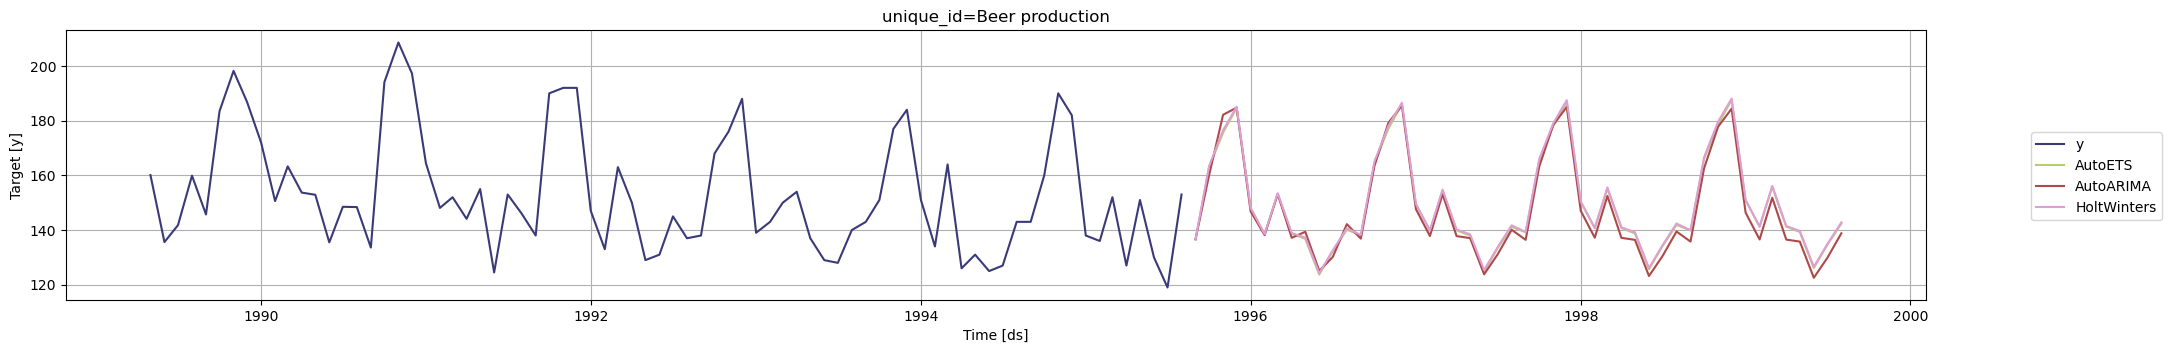

In [9]:
# Tässä piirretään kolmen mallin antamat ennusteet päällekkäin samaan kaavioon
sf.plot(df[400:], forecasts_df)

## Mallien arviointia

Malleja voidaan arvoida **cross_validation**-funktiolla. Käytän tässä cross_validation-funtiota yksinkertaisimmalla mahdollisella tavalla, jossa viimeisen vuoden tietoja käytetään testidatana. Parametrien arvoja:

* h=12 tarkoittaa sovitettujen arvojen laskemista 12 kuukaudelle kerrallaan
* n_windows=1 rajoittaa sovitettujen arvojen laskemisen viimeisen 12 kuukauden ajalle.

In [10]:
crossvalidation_df = sf.cross_validation(
    df=df,
    h=12,
    n_windows=1
)

In [11]:
# Sovitetut arvot eri menetelmillä viimeisille 12 kuukaudelle
crossvalidation_df

,unique_id,ds,cutoff,y,AutoETS,AutoARIMA,HoltWinters
0,Beer production,1994-09-01,1994-08-01,143.0,138.315277,134.574585,133.369263
1,Beer production,1994-10-01,1994-08-01,160.0,158.139008,158.419113,160.591797
2,Beer production,1994-11-01,1994-08-01,190.0,166.895706,174.286682,171.244263
3,Beer production,1994-12-01,1994-08-01,182.0,178.559067,183.368668,181.761612
4,Beer production,1995-01-01,1994-08-01,138.0,147.811691,147.156799,145.549179
5,Beer production,1995-02-01,1994-08-01,136.0,138.353333,134.574127,134.750687
6,Beer production,1995-03-01,1994-08-01,152.0,149.104538,152.523438,149.073486
7,Beer production,1995-04-01,1994-08-01,127.0,134.579208,134.336456,135.473495
8,Beer production,1995-05-01,1994-08-01,151.0,129.997772,131.163223,130.454315
9,Beer production,1995-06-01,1994-08-01,130.0,115.893456,120.277473,118.099243


Parhaan mallin valitsemiseen käytän seuraavassa virheiden neliöiden keskiarvoa (**mse** = mean squared error):

In [12]:
# Lista käytetyistä malleista
models_list = crossvalidation_df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.to_list()
# Mallien arviointi mse:n avulla
evaluation_df = evaluate(crossvalidation_df, metrics=[mse], models=models_list)
# Parhaan mallin tunnistaminen
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
evaluation_df

,unique_id,metric,AutoETS,AutoARIMA,HoltWinters,best_model
0,Beer production,mse,156.669052,112.978432,135.619186,AutoARIMA


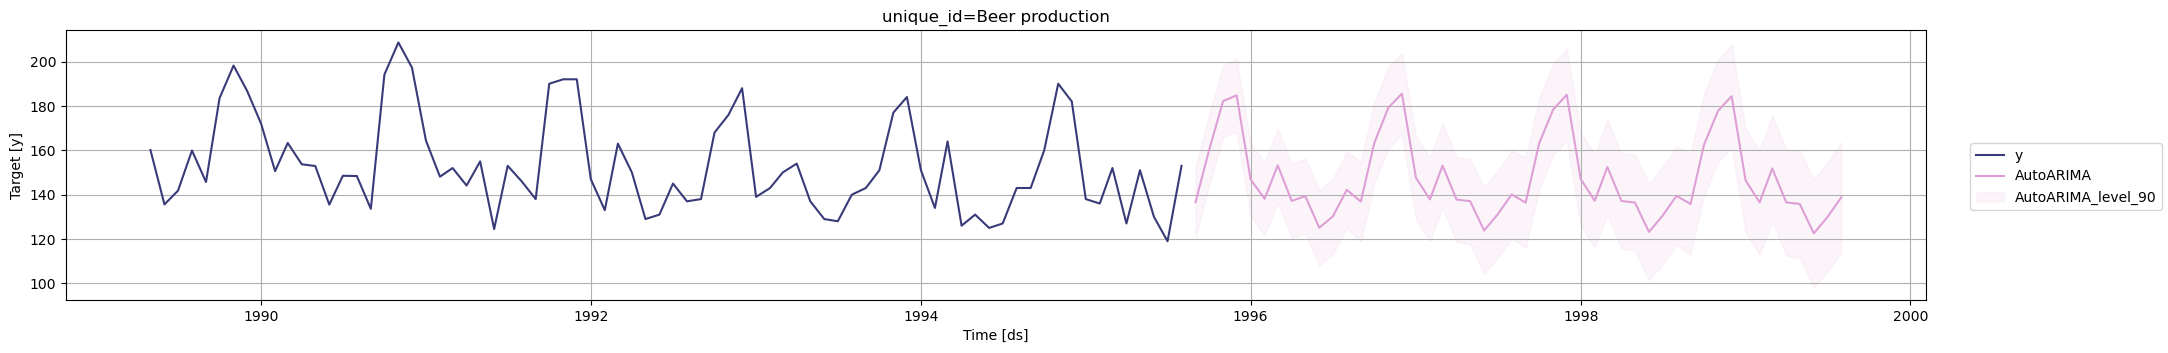

In [13]:
# Paras malli luottamusväleineen (90 %) grafiikkana
sf.plot(df[400:], forecasts_df, models=[evaluation_df.loc[0, 'best_model']], level=[90])

Katsotaan parasta mallia vielä hieman tarkemmin sovittamalla malli **fit**-funktiolla. Parametrin **trace=True** ansiosta näen kokeillut mallit ja niiden **AICc**-arvot (informaatiokriteeri, jonka perusteella malli on valittu). 

In [14]:
sf_final = StatsForecast( 
    models=[AutoARIMA(season_length=12, trace=True)],
    freq='MS', 
    n_jobs=-1,
)
sf_final.fit(df)


ARIMA(2,1,2)(1,1,1)[12]                   :3453.166855663393

ARIMA(0,1,0)(0,1,0)[12]                   :4010.5665523478647

ARIMA(1,1,0)(1,1,0)[12]                   :3817.433940168746

ARIMA(0,1,1)(0,1,1)[12]                   :3483.733861633272

ARIMA(2,1,2)(0,1,1)[12]                   :3459.410381051772

ARIMA(2,1,2)(1,1,0)[12]                   :3560.001232379464

ARIMA(2,1,2)(2,1,1)[12]                   :3453.0269123772696

ARIMA(2,1,2)(2,1,0)[12]                   :3536.975174376098

ARIMA(2,1,2)(2,1,2)[12]                   :3463.752137965238

ARIMA(2,1,2)(1,1,2)[12]                   :3453.054750018064

ARIMA(1,1,2)(2,1,1)[12]                   :3453.104548906826

ARIMA(2,1,1)(2,1,1)[12]                   :3453.7618367012824

ARIMA(3,1,2)(2,1,1)[12]                   :3453.1825922367825

ARIMA(2,1,3)(2,1,1)[12]                   :3443.9096112357724

ARIMA(2,1,3)(1,1,1)[12]                   :inf

ARIMA(2,1,3)(2,1,0)[12]                   :5322.274048851433

ARIMA(2,1,3)(2,1

StatsForecast(models=[AutoARIMA])

Edellisen perusteella malliksi valikoitui **ARIMA(3, 1, 3)(0, 1, 2)[12]**, koska sen kohdalla **AICc** arvo oli pienin.

Kausivaihtelun huomioivassa ARIMA-mallissa ensimmäinen lukukolmikko liittyy aikasarjan perusvaihteluun (poislukien kausivaihtelu) ja toinen lukukolmikko liittyy kausivaihteluun. Viimeisin luku (12) kertoo kausivaihelun pituuden (tässä kausivaihelu toistuu 12 kuukauden jaksoissa).

Lukukolmikot saavat selityksensä mallin rakenteesta. ARIMA on lyhenne nimestä **AutoRegressive Integrated Moving Average** eli mallissa on kolme osaa, joita seuraavassa yritän yksinkertaistaen hahmottaa:

* **AutoRegressive**: Aikasarjan arvot saattavat korreloida aikaisempien arvojen kanssa. Autoregressio-luku kertoo kuinka monta havaintoa taaksepäin ulottuvia korrelaatioita otetaan huomioon. Esimerkissämme perusvaihtelun osalta huomioidaan korrelaatioita kolme havaintoa taaksepäin, mutta kausivaihelun osalta korrelaatiota ei huomioida.
* **Integrated**: ARIMA-mallia käytettäessä aikasarjan pitäisi olla stationaarinen, joka yksinkertaistettuna tarkoittaa että keskiarvo ja keskihajonta pysyvät ajankuluessa kuta kuinkin vakioina. Ei-stationaarinen aikasarja muutetaan stationaariseksi vähentämällä aikasarjan arvosta aiempi arvo (lasketaan aikasarjassa tapahtunut muutos).  Integreated-luku kertoo kuinka monta kertaa tämä toimenpide täytyy tehdä aikasarjan muuttamiseksi stationaariseksi. Esimerkissämme vähentäminen tehdään vain kerran sekä perusvaihtelun että kausivaihtelun osalta.
* **Moving Average**: Liukuvien keskiarvojen avulla voidaan tunnistaa lyhyen aikavälin trendejä. Moving Average -luku kertoo kuinka monen havainnon liukuvia keskiarvoja lasketaan. Perusvaihtelun osalta lasketaan kolmen havainnon liukuvia keskiarvoja ja kausivaihtelun osalta kahden havainnon liukuvia keskiarvoja.


Vilkaistaan vielä lopuksi kahta muuta mallia sovittamalla mallit ja katsomalla minkälaiset komponentit niihin valikoitui.

In [15]:
sf_holtwinter = StatsForecast( 
    models=[HoltWinters(season_length=12)],
    freq='MS', 
    n_jobs=-1,
)
sf_holtwinter.fit(df)

# Tätä ei statsforecast-kirjaston dokumentaatiosta löytynyt, mutta näin mallin komponentit saa selville:
sf_holtwinter.fitted_[0, 0].model_['components']

'AAAD'

ETS-mallin komponentti voi olla additiivinen (A), multiplikatiivinen (M) tai puuttua kokonaan (N). Edellä mallin komponentit ovat:

* Additiivinen virhetermi
* Additiivinen trendi
* Additiivinen kausivaihtelu
* Viimeisen kirjaimen (D) selitystä en ole löytänyt?

In [16]:
sf_autoets = StatsForecast( 
    models=[AutoETS(season_length=12)],
    freq='MS', 
    n_jobs=-1,
)
sf_autoets.fit(df)

# Tätä ei statsforecast-kirjaston dokumentaatiosta löytynyt, mutta näin mallin komponentit saa selville:
sf_autoets.fitted_[0, 0].model_['components']

'MAAD'

Mallin komponentit ovat siis seuraavat:

* Multiplikatiivinen virhetermi
* Additiivinen trendi
* Additiivinen kausivaihtelu
* Viimeisen kirjaimen (D) selitystä en ole löytänyt?

## Lisätietoa

Nixtlan sivuilta löydät pidemmälle menevän esimerkin, jossa usean mallin lisäksi on samanaikaisesti mukana useita aikasarjoja:
https://nixtlaverse.nixtla.io/statsforecast/docs/getting-started/getting_started_complete.html